In [103]:
import pandas as pd
import seaborn as sns

# load dataframe
df = pd.read_csv("../data/bank-full.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [104]:
import numpy as np
from scipy import stats

# what am I doing here? (z-score = how many standard deviations a sample is away from the mean)
# remove outliers: 100_000 euros in their bank account 
df = df[(np.abs(stats.zscore(df['balance'])) < 3)]

# set y to binary
df['y'] = np.where(df['y'] == 'yes', 1, 0)

# drop time (for simplicity)
# drop until we get more domain information on this variable
# drop columns that are not controlled by marketers
# time is SUPER tricky, so for now its best to avoid it. We could potentially mislead ourselves by including time.
df.drop(columns=["day", "month", "duration"], inplace=True)

# one hot encoding
df['job'] = df['job'].astype('category')
df['marital'] = df['marital'].astype('category')
df['education'] = df['education'].astype('category')
df['default'] = df['default'].astype('category')
df['housing'] = df['housing'].astype('category')
df['loan'] = df['loan'].astype('category')
df['contact'] = df['contact'].astype('category')
df['poutcome'] = df['poutcome'].astype('category')

df = pd.get_dummies(df)

df = df.apply(lambda x: x.astype(float))

df.to_csv("../data/bank-cleaned.csv", index=False)

In [116]:
df['pdays'] = np.where(df['pdays'] == -1, 0, df['pdays'])
df.drop(columns=["housing_no", "default_no"], inplace=True)

KeyError: "['housing_no', 'default_no'] not found in axis"

In [109]:
df[["default_yes", "default_no"]].head()

# PERFECT EXAMPLE OF CO-LINEARITY (when one value is x, the other value is guaranteed to by y). Terrible for our model because it will introduce noise.

,default_yes,default_no
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [112]:
df.head()

,age,balance,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58.0,2143.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,44.0,29.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,33.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,47.0,1506.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,33.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn import tree

# make test train split
# train [r, c] 
# 1:5 --> all rows (1,2,3,4 (excluding 5))
# df.columns != 'y' (all except `y`)
X = df.loc[:, df.columns != 'y']
# target
y = df["y"]

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.20, random_state=42)

In [119]:
# Logistic Regression
log = LogisticRegression(random_state=0, max_iter = 10_000)
log.fit(X_train, y_train)

for i in range(len(X.columns)):
  print(X.columns[i], log.coef_[0][i])

age 0.0001759418721801049
balance 6.417284396524956e-05
campaign -0.11436648067919325
pdays -0.0004074661197113484
previous 0.0016805449965329369
job_admin. -0.00020850979462701483
job_blue-collar -0.2631458912502494
job_entrepreneur -0.13052870317609214
job_housemaid -0.12989978317525083
job_management -0.1405971454329803
job_retired 0.41671674013524096
job_self-employed -0.09303625187290737
job_services -0.1520866724230078
job_student 0.1949738701685148
job_technician -0.18984508884604584
job_unemployed 0.05572852644464266
job_unknown -0.02551915605214915
marital_divorced -0.12675075154106477
marital_married -0.37455245830953987
marital_single 0.04385514458319101
education_primary -0.2983123978082449
education_secondary -0.1460923175286846
education_tertiary 0.015693421662551783
education_unknown -0.028736771653062473
default_yes -0.07725963025854496
housing_yes -0.5432360140322793
loan_no 0.08313704112899482
loan_yes -0.5405851064440587
contact_cellular 0.2644596266377486
contact_te

In [93]:
predictions = log.predict(X_test)

# generate confusion matrix
confusion_matrix(y_test, predictions)

array([[7821,   89],
       [ 828,  156]], dtype=int64)

In [94]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

(tn, fp, fn, tp)

(7821, 89, 828, 156)

In [89]:
# calculate accuracy
log.score(X_test, y_test)

0.8968967843489993

In [90]:
from sklearn.metrics import recall_score, precision_score

recall_score(y_test, predictions)

0.15853658536585366

In [95]:
precision_score(y_test, predictions)

0.636734693877551

In [120]:
## Alternative logistic regression
import statsmodels.api as sm

model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = model.fit()
results.params

age                    0.002564
balance                0.000068
campaign              -0.107568
pdays                  0.000285
previous               0.006986
job_admin.            -0.019307
job_blue-collar       -0.212301
job_entrepreneur      -0.312126
job_housemaid         -0.334912
job_management        -0.170194
job_retired            0.446677
job_self-employed     -0.220804
job_services          -0.147763
job_student            0.456355
job_technician        -0.172932
job_unemployed         0.087876
job_unknown           -0.251408
marital_divorced      -0.240987
marital_married       -0.489086
marital_single        -0.120768
education_primary     -0.388006
education_secondary   -0.235189
education_tertiary    -0.037857
education_unknown     -0.189789
default_yes           -0.231741
housing_yes           -0.553213
loan_no               -0.201394
loan_yes              -0.649447
contact_cellular       0.112114
contact_telephone     -0.110219
contact_unknown       -0.852736
poutcome

In [121]:
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                35572
Model:                            GLM   Df Residuals:                    35542
Model Family:                Binomial   Df Model:                           29
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11068.
Date:                Mon, 08 May 2023   Deviance:                       22137.
Time:                        19:18:04   Pearson chi2:                 3.71e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.09698
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
age                     0.0026    

In [96]:
# DECISION TREE
treeclf = tree.DecisionTreeClassifier(max_depth=2)
treeresults = treeclf.fit(X_train, y_train)

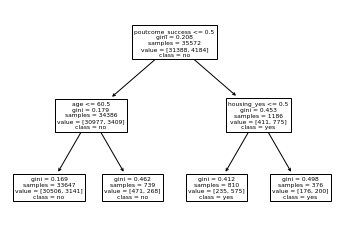

In [97]:
import matplotlib.pyplot as plt

tree.plot_tree(treeclf, feature_names=X.columns, class_names=["no", "yes"])
plt.savefig('tree.pdf',format='pdf',bbox_inches = "tight")

In [98]:
y_pred = treeclf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[7799,  111],
       [ 811,  173]], dtype=int64)

In [101]:
treeclf.score(X_test, y_test)

0.8963346076006297

In [99]:
recall_score(y_test, y_pred)

0.1758130081300813

In [100]:
precision_score(y_test, y_pred)

0.6091549295774648

In [74]:
from sklearn.ensemble import RandomForestClassifier

# ENSEMBLE METHODS: RANDOM FORESTS
randomclf = RandomForestClassifier(max_depth=5, random_state=0)
randomclfresults = randomclf.fit(X_train, y_train)

In [75]:
y_pred = randomclf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[7842,   68],
       [ 857,  127]], dtype=int64)